In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = 'darkgrid')

import pickle
from utils import scatter_plot, qqplot
from sklearn.preprocessing import StandardScaler

In [2]:
hydro_set = pd.read_csv('./data/HYDRoSWOT_subset.csv', converters={'site_no': str}, low_memory=False)
train = pd.read_csv('./data/HYDRoSWOT_subset_train.csv', converters={'site_no': str}, low_memory=False)
test = pd.read_csv('./data/HYDRoSWOT_subset_test.csv', converters={'site_no': str}, low_memory=False)

In [3]:
tauraat_sc1 = pd.read_csv('./data/tauraat_subset_sc1.csv', converters={'site_no': str}, low_memory=False)
tauraat_sc2 = pd.read_csv('./data/tauraat_subset_sc2.csv', converters={'site_no': str}, low_memory=False)

In [7]:
X_train = train.drop(columns=['site_no', 'mean_depth_va', 'site_tp_cd'])
X_test = test.drop(columns=['site_no', 'mean_depth_va', 'site_tp_cd'])

y_train = train[['mean_depth_va']]
y_test = test[['mean_depth_va']]

In [8]:
X_train_ = X_train.copy(deep=True)
X_train_['drain_area_va'] = np.log10(X_train['drain_area_va'])
X_train_['q_va'] = np.log10(X_train['q_va'])
X_train_['stream_wdth_va'] = np.log10(X_train['stream_wdth_va'])
X_train_['xsec_area_va'] = np.log10(X_train['xsec_area_va'])
y_train_= np.log10(y_train)

X_scaler = StandardScaler()
X_train_ = X_scaler.fit_transform(X_train_).astype('float32')

y_scaler = StandardScaler()
y_train_ = y_scaler.fit_transform(np.array(y_train_).reshape(-1, 1)).astype('float32').ravel()

X_test_ = X_test.copy(deep=True)
X_test_['drain_area_va'] = np.log10(X_test['drain_area_va'])
X_test_['q_va'] = np.log10(X_test['q_va'])
X_test_['stream_wdth_va'] = np.log10(X_test['stream_wdth_va'])
X_test_['xsec_area_va'] = np.log10(X_test['xsec_area_va'])

X_test_ = X_scaler.transform(X_test_).astype('float32')

In [44]:
candidates=['site_no', 'drain_area_va', 'chan_discharge', 'gage_height_va', 'chan_width', 'chan_area', 'chan_velocity']
tauraat_sc1 = tauraat_sc1[candidates]

In [24]:
tauraat_sc1.describe()

,drain_area_va,chan_discharge,gage_height_va,chan_width,chan_area,chan_velocity
count,1.659602e+06,1.659602e+06,1.659602e+06,1.659602e+06,1.659602e+06,1.659602e+06
mean,1.455966e+04,4.792644e+03,8.519245e+00,1.648522e+02,1.474255e+03,1.731131e+00
std,7.532694e+04,3.252788e+04,3.865982e+01,3.154378e+02,7.409041e+03,1.307601e+01
min,1.000000e-02,-2.330000e+05,-7.450000e+02,2.000000e-02,1.000000e-02,-3.800000e+01
25%,1.220000e+02,4.130000e+01,2.330000e+00,4.080000e+01,4.480000e+01,8.000000e-01
50%,4.230000e+02,2.030000e+02,3.820000e+00,8.200000e+01,1.510000e+02,1.350000e+00
75%,1.673000e+03,1.080000e+03,6.830000e+00,1.680000e+02,6.300000e+02,2.160000e+00
max,1.144500e+06,2.260000e+06,8.440000e+03,3.810000e+04,6.950000e+05,8.620000e+03


In [46]:
tauraat_sc1 = tauraat_sc1[tauraat_sc1['chan_discharge'] > 0]

In [48]:
rename_columns={'gage_height_va':'stage_va', 'chan_discharge': 'q_va', 'chan_width': 'stream_wdth_va', 'chan_area': 'xsec_area_va', 'chan_velocity': 'mean_vel_va'}
tauraat_sc1 = tauraat_sc1.rename(columns=rename_columns)

In [49]:
tauraat_sc1_ = tauraat_sc1.drop(columns=['site_no']).copy(deep=True)
tauraat_sc1_['drain_area_va'] = np.log10(tauraat_sc1['drain_area_va'])
tauraat_sc1_['q_va'] = np.log10(tauraat_sc1['q_va'])
tauraat_sc1_['stream_wdth_va'] = np.log10(tauraat_sc1['stream_wdth_va'])
tauraat_sc1_['xsec_area_va'] = np.log10(tauraat_sc1['xsec_area_va'])

tauraat_sc1_ = X_scaler.transform(tauraat_sc1_).astype('float32')

In [28]:
with open('./data/ml_weights/mlp_best_model', "rb") as fp:
    mlp = pickle.load(fp)

In [41]:
y_pred = mlp.predict(tauraat_sc1_)
y_pred = y_scaler.inverse_transform(y_pred.reshape(-1, 1)).ravel()
y_pred = 10 ** y_pred

In [51]:
tauraat_sc1['synth_depth'] = y_pred

In [37]:
sites = hydro_set['site_no'].value_counts()

site number: 06893000, HYDRoSWOT: 155, TAURAAT: 1737


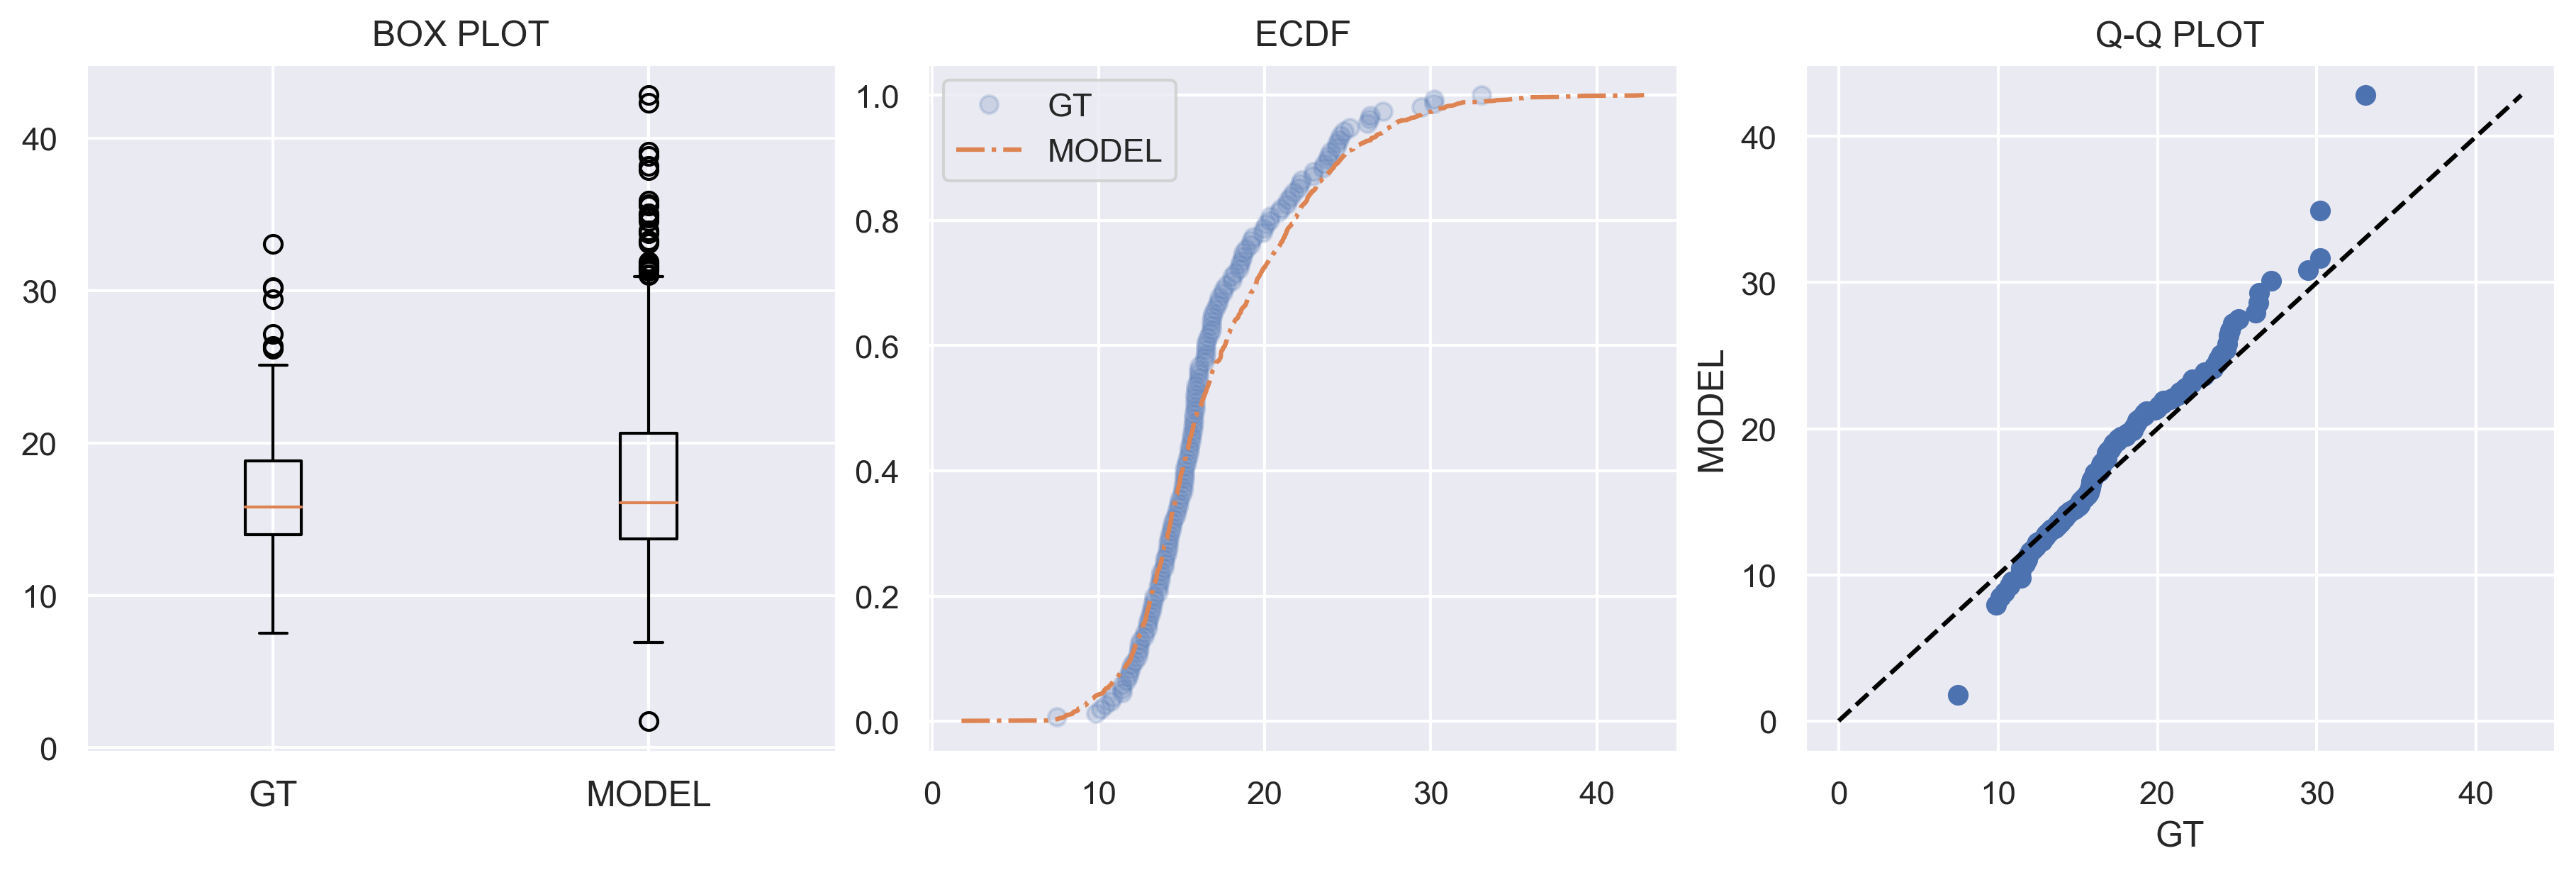

site number: 06813500, HYDRoSWOT: 144, TAURAAT: 3678


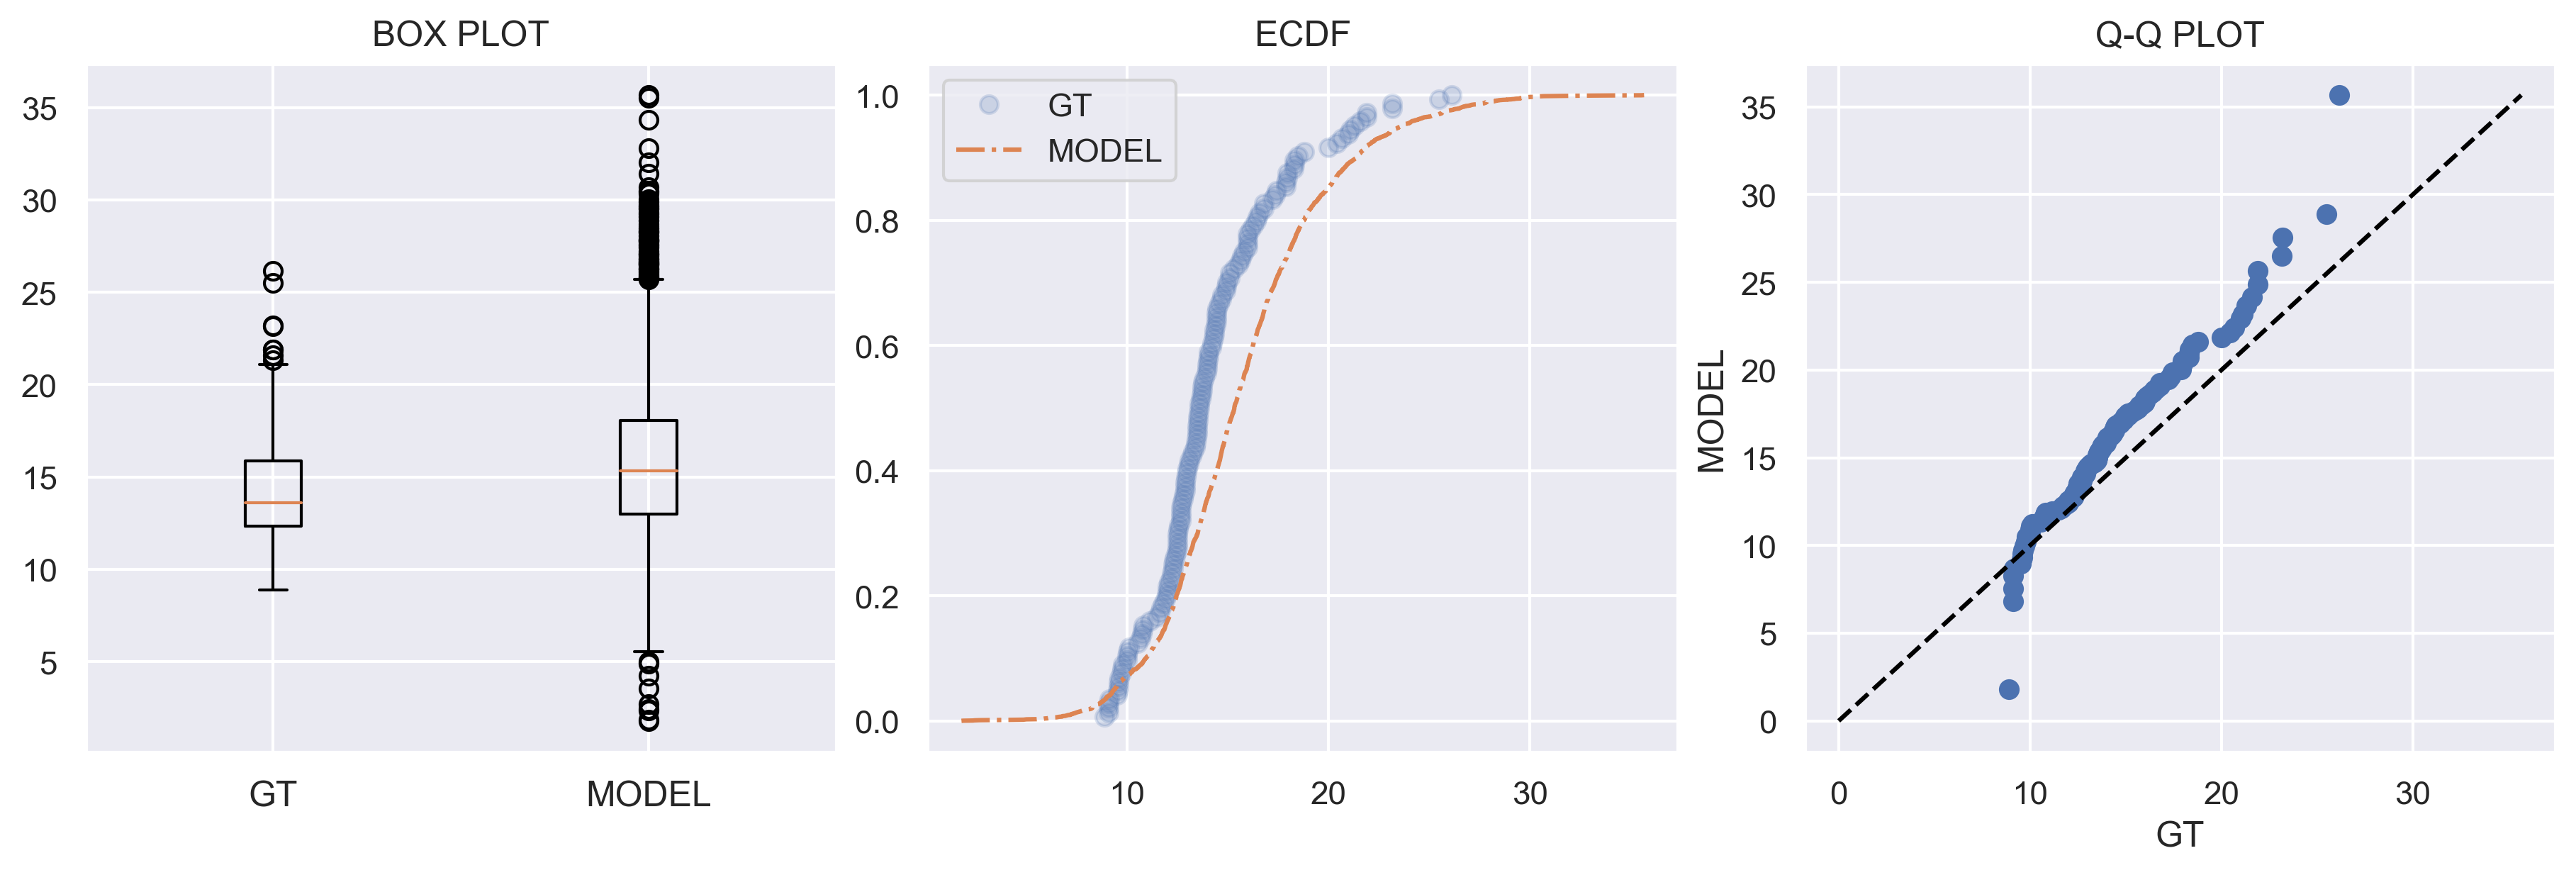

In [53]:
for idx, site in enumerate(sites.iloc[:2]):
    data1 = hydro_set[hydro_set['site_no'] == sites.index[idx]]['mean_depth_va'].values
    data2 = tauraat_sc1[tauraat_sc1['site_no'] == sites.index[idx]]['synth_depth'].values
    print(f'site number: {sites.index[idx]}, HYDRoSWOT: {data1.shape[0]}, TAURAAT: {data2.shape[0]}')
    qqplot(data1, data2)